In [215]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array

import pickle

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import merge, Input
from keras.applications import VGG16
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D

from keras.models import Model
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [71]:
def change_labels(labels):
    new_labels = []
    for elem in labels:
        if elem == 0:
            new_labels.append('bee')
        elif elem == 1:
            new_labels.append('insect')
        elif elem == 2:
            new_labels.append('other')
        elif elem == 3:
            new_labels.append('wasp')
        
    return new_labels           

In [12]:
def change_labels_tonum(label):
    if label == 'bee':
        new_label = 0
    elif label == 'insect':
        new_label = 1
    elif label == 'other':
        new_label = 2
    elif label == 'wasp':
        new_label = 3
        
    return new_label   

In [13]:
model_last1 = load_model('last_layer_trained_model.h5')
model_last2 = load_model('last_2_layers_trained_model.h5')
model_full = load_model('full_trained_model.h5')
model_removed = load_model('full_trained_model_removed_layers.h5')
model_1 = load_model('classifiaction_layer_trained_model')


In [14]:
train_dir = "kaggle_bee_vs_wasp/"
resize_size = 224
bees_vs_wasps_dataset_path=Path(train_dir)

In [131]:
training_subsample = 0.1
#insect_class = {'bee': 0,'wasp': 1, 'insect': 2,'other': 3} 

df_labels = pd.read_csv(bees_vs_wasps_dataset_path/'labels.csv')
df_labels = df_labels.set_index('id')
df_labels = df_labels.sample(frac=training_subsample, axis=0)
df_labels = df_labels[['path','label']]
df_labels = df_labels.reset_index(drop=True)
df_labels

,path,label
0,bee1\35210574453_d4fd6a8722_w.jpg,bee
1,bee1\9973900213_08ff7f2791_w.jpg,bee
2,bee2\P3570-37r.jpg,bee
3,wasp2\F00429.jpg,wasp
4,wasp2\H00222.jpg,wasp
...,...,...
1137,other_insect\8205128567_4e771bdc73_m.jpg,insect
1138,wasp1\27265699770_c84734ddc1_m.jpg,wasp
1139,bee1\8854521730_f2822d3a95_w.jpg,bee
1140,other_insect\23674795368_eb0a139a94_n.jpg,insect


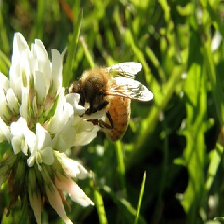

In [16]:
sample = df_labels.sample()
image_path = sample.path
image_path = image_path.replace('\\','/')
image = load_img(train_dir + image_path.values[0], target_size=(resize_size, resize_size))
image

In [17]:
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
predictions = model_full.predict(image)

print(predictions)
predicted_class = np.argmax(predictions)
print(predicted_class)
print(sample.label)

[[1. 0. 0. 0.]]
0
94    bee
Name: label, dtype: object


##  Last layer trained 

In [138]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_labels, 
    train_dir, 
    x_col='path',
    y_col='label',
    class_mode='sparse',
    target_size=(resize_size, resize_size),
    batch_size=1,
    shuffle = False,
)
pred=model_last1.predict(test_generator, steps=len(df_labels), verbose=1)
pred_labels = np.argmax(pred,axis=1)
pred_labels = change_labels(pred_labels)
real_labels = df_labels.label.to_numpy()

Found 1142 validated image filenames belonging to 4 classes.
1142/1142 [==============================] - 174s 153ms/step


<AxesSubplot:>

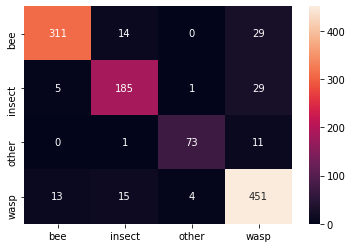

In [139]:
label_names = ['bee','insect','other','wasp']
matrix_last1 = confusion_matrix(real_labels, pred_labels)
sns.heatmap(matrix_last1, annot = True, fmt='g', xticklabels = label_names, yticklabels=label_names)

## Last 2 layers trained 

In [140]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_labels, 
    train_dir, 
    x_col='path',
    y_col='label',
    class_mode='sparse',
    target_size=(resize_size, resize_size),
    batch_size=1,
    shuffle = False,
)
pred=model_last2.predict(test_generator, steps=len(df_labels), verbose=1)
pred_labels = np.argmax(pred,axis=1)
pred_labels = change_labels(pred_labels)
real_labels = df_labels.label.to_numpy()

Found 1142 validated image filenames belonging to 4 classes.
1142/1142 [==============================] - 174s 153ms/step


<AxesSubplot:>

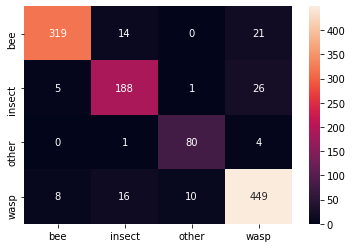

In [142]:
label_names = ['bee','insect','other','wasp']
matrix_last2 = confusion_matrix(real_labels, pred_labels)
sns.heatmap(matrix_last2, annot = True, fmt='g', xticklabels = label_names, yticklabels=label_names)

## Full trained model 

In [143]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_labels, 
    train_dir, 
    x_col='path',
    y_col='label',
    class_mode='sparse',
    target_size=(resize_size, resize_size),
    batch_size=1,
    shuffle = False,
)
pred=model_full.predict(test_generator, steps=len(df_labels), verbose=1)
pred_labels = np.argmax(pred,axis=1)
pred_labels = change_labels(pred_labels)
real_labels = df_labels.label.to_numpy()

Found 1142 validated image filenames belonging to 4 classes.
1142/1142 [==============================] - 175s 153ms/step


<AxesSubplot:>

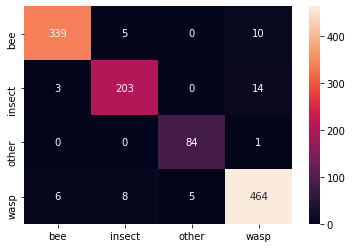

In [144]:
label_names = ['bee','insect','other','wasp']
matrix_full = confusion_matrix(real_labels, pred_labels)
sns.heatmap(matrix_full, annot = True, fmt='g', xticklabels = label_names, yticklabels=label_names)

## Full trained model removed layers 

In [145]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_labels, 
    train_dir, 
    x_col='path',
    y_col='label',
    class_mode='sparse',
    target_size=(resize_size, resize_size),
    batch_size=1,
    shuffle = False,
)
pred=model_removed.predict(test_generator, steps=len(df_labels), verbose=1)
pred_labels = np.argmax(pred,axis=1)
pred_labels = change_labels(pred_labels)
real_labels = df_labels.label.to_numpy()

Found 1142 validated image filenames belonging to 4 classes.
1142/1142 [==============================] - 174s 152ms/step


<AxesSubplot:>

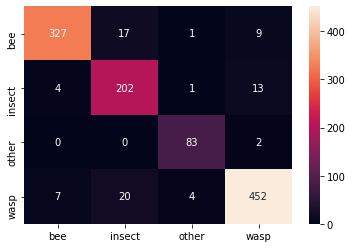

In [146]:
label_names = ['bee','insect','other','wasp']
matrix_removed = confusion_matrix(real_labels, pred_labels)
sns.heatmap(matrix_removed, annot = True, fmt='g', xticklabels = label_names, yticklabels=label_names)

## Only classificator trained 

In [196]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_labels, 
    train_dir, 
    x_col='path',
    y_col='label',
    class_mode='sparse',
    target_size=(resize_size, resize_size),
    batch_size=1,
    shuffle = False,
)
pred=model_1.predict(test_generator, steps=len(df_labels), verbose=1)
pred_labels = np.argmax(pred,axis=1)
pred_labels = change_labels(pred_labels)
real_labels = df_labels.label.to_numpy()

Found 1142 validated image filenames belonging to 4 classes.
1142/1142 [==============================] - 182s 159ms/step


<AxesSubplot:>

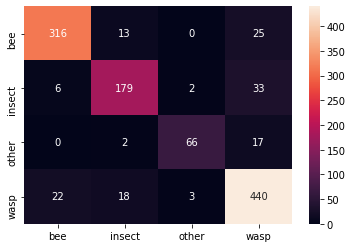

In [197]:
label_names = ['bee','insect','other','wasp']
matrix_1 = confusion_matrix(real_labels, pred_labels)
sns.heatmap(matrix_1, annot = True, fmt='g', xticklabels = label_names, yticklabels=label_names)

In [270]:
model_linear = pickle.load(open('lin_svm.sav', 'rb'))

c:\users\mateusz\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator SVC from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [263]:
(model_linear)

SVC(degree=2, kernel='poly')

In [264]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_labels, 
    train_dir, 
    x_col='path',
    y_col='label',
    class_mode='sparse',
    target_size=(resize_size, resize_size),
    batch_size=1,
    shuffle = False,
)

Found 1142 validated image filenames belonging to 4 classes.


In [216]:
image_input = Input(shape=(resize_size, resize_size, 3))
model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')
last_layer = model.get_layer('block5_pool')
last_output = last_layer.output
x = Flatten()(last_output)
custom_vgg_model = Model(image_input, x)
custom_vgg_model.compile(loss='sparse_categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
for layer in custom_vgg_model.layers:
    layer.trainable = False

In [219]:
pred=custom_vgg_model.predict(test_generator, steps=len(df_labels), verbose=1)

1142/1142 [==============================] - 175s 153ms/step


In [265]:
pred.shape

(1142, 25088)

In [266]:
pred[0].shape

(25088,)

In [267]:
pred[0].reshape(1,-1)

array([[0.       , 0.       , 0.       , ..., 0.       , 0.6449874,
        0.       ]], dtype=float32)

In [271]:
model_linear.predict(pred)

AttributeError: 'SVC' object has no attribute '_probA'